

Import common package

In [1]:

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np


from qcat.analysis.state_discrimination.readout_fidelity import GMMROFidelity


c:\Users\shiau\.conda\envs\PYQUM-server-offline\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


File formate translate (QM)

In [2]:
dataset = xr.open_dataset(r"d:\Data\Qubit\5Q4C0510_DR1_AS16\20240619_1603_ro_map_q4_xy.nc")
print(dataset)
transposed_data = dataset.transpose( "amp_ratio", "frequency", "mixer", "prepare_state", "shot")
transposed_data = transposed_data.rename({'shot': 'index'})

format_data = {}
for ro_name, data in transposed_data.data_vars.items(): 
    new_data = data.values*1000
    format_data[ro_name] = new_data
    print(ro_name)


<xarray.Dataset> Size: 50MB
Dimensions:        (mixer: 2, shot: 1000, frequency: 60, amp_ratio: 13,
                    prepare_state: 2)
Coordinates:
  * mixer          (mixer) <U1 8B 'I' 'Q'
  * frequency      (frequency) float64 480B -3.0 -2.9 -2.8 -2.7 ... 2.7 2.8 2.9
  * amp_ratio      (amp_ratio) float64 104B 0.2 0.3 0.4 0.5 ... 1.1 1.2 1.3 1.4
  * prepare_state  (prepare_state) int32 8B 0 1
  * shot           (shot) int32 4kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
Data variables:
    q3_ro          (mixer, shot, frequency, amp_ratio, prepare_state) float64 25MB ...
    q4_ro          (mixer, shot, frequency, amp_ratio, prepare_state) float64 25MB ...
Attributes:
    ro_LO:       [6130000000 6130000000]
    ro_IF:       [ -60000000 -178800000]
    xy_LO:       5100000000
    xy_IF:       -145180000
    start_time:  20240619_155528
    end_time:    20240619_160322
q3_ro
q4_ro


File formate translate (Qblox)

Create Discriminator object to analyze data

In [3]:
import warnings

# Suppress the specific UserWarning related to KMeans and MKL
warnings.filterwarnings("ignore", category=UserWarning)

ro_name = "q4_ro"

freq = transposed_data.coords["frequency"].values
amp = transposed_data.coords["amp_ratio"].values

training_data = format_data[ro_name] #your (2,2,N) data to train
print(training_data.shape)
map_shape = (training_data.shape[0],training_data.shape[1])
snr = np.zeros( map_shape )
p01 = np.zeros( map_shape )
import os
# Set the number of threads to avoid the warning
os.environ["OMP_NUM_THREADS"] = "8"  # Or any appropriate number of threads
for i in range(map_shape[0]):
    for j in range(map_shape[1]):
        print(i, amp[i], j, freq[j])
        analysis_data = training_data[i][j] #your (2,2,N) data to analysis
        dataset = xr.DataArray(analysis_data, coords= [("mixer",["I","Q"]), ("prepared_state",[0,1]), ("index",np.arange(analysis_data.shape[2]))] )
        
        # Do analysis
        gmm2d_fidelity = GMMROFidelity()
        gmm2d_fidelity._import_data(dataset)
        gmm2d_fidelity._start_analysis()
        g1d_fidelity = gmm2d_fidelity.export_G1DROFidelity()
        # print(p0_result.fit_report())
        dis = g1d_fidelity.discriminator.signal
        sigma = np.max( g1d_fidelity.discriminator.noise )
        snr[i][j]=dis/sigma
        p01[i][j] = g1d_fidelity.g1d_dist[0][0][1]



(13, 60, 2, 2, 1000)
0 0.2 0 -3.0
hist [-4.62283183e-02 -4.54311997e-02 -4.46340810e-02 -4.38369623e-02
 -4.30398436e-02 -4.22427249e-02 -4.14456063e-02 -4.06484876e-02
 -3.98513689e-02 -3.90542502e-02 -3.82571315e-02 -3.74600128e-02
 -3.66628942e-02 -3.58657755e-02 -3.50686568e-02 -3.42715381e-02
 -3.34744194e-02 -3.26773008e-02 -3.18801821e-02 -3.10830634e-02
 -3.02859447e-02 -2.94888260e-02 -2.86917074e-02 -2.78945887e-02
 -2.70974700e-02 -2.63003513e-02 -2.55032326e-02 -2.47061139e-02
 -2.39089953e-02 -2.31118766e-02 -2.23147579e-02 -2.15176392e-02
 -2.07205205e-02 -1.99234019e-02 -1.91262832e-02 -1.83291645e-02
 -1.75320458e-02 -1.67349271e-02 -1.59378084e-02 -1.51406898e-02
 -1.43435711e-02 -1.35464524e-02 -1.27493337e-02 -1.19522150e-02
 -1.11550964e-02 -1.03579777e-02 -9.56085900e-03 -8.76374031e-03
 -7.96662163e-03 -7.16950295e-03 -6.37238427e-03 -5.57526559e-03
 -4.77814691e-03 -3.98102823e-03 -3.18390954e-03 -2.38679086e-03
 -1.58967218e-03 -7.92553499e-04  4.56518207e-06  8

c:\Users\shiau\.conda\envs\PYQUM-server-offline\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


ValueError: NaN values detected in your input data or the output of your objective/model function - fitting algorithms cannot handle this! Please read https://lmfit.github.io/lmfit-py/faq.html#i-get-errors-from-nan-in-my-fit-what-can-i-do for more information.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


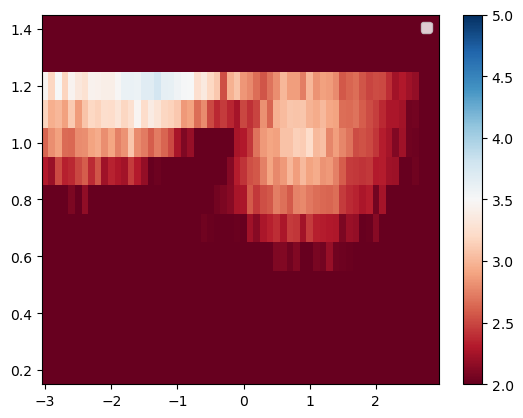

In [ ]:
plt.pcolormesh( freq, amp, snr, cmap='RdBu', vmin=2, vmax=5)
# plt.pcolormesh( freq, amp, p01, cmap='RdBu', vmin=0, vmax=0.1 )

plt.colorbar()
plt.legend()